<a href="https://colab.research.google.com/github/stepanl-bsy/langgraph_tutorial/blob/main/2_lang_langgraph_components_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%pip install -q langgraph  langchain langchain_community langchain_google_genai
# google-cloud-aiplatform vertexai langgraph langchain_google_vertexai

## Langgraph
https://www.langchain.com/langgraph

Modified from: from deeplearning.ai:
https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/
https://github.com/grbcool/AI-Agents-in-the-LangGraph/

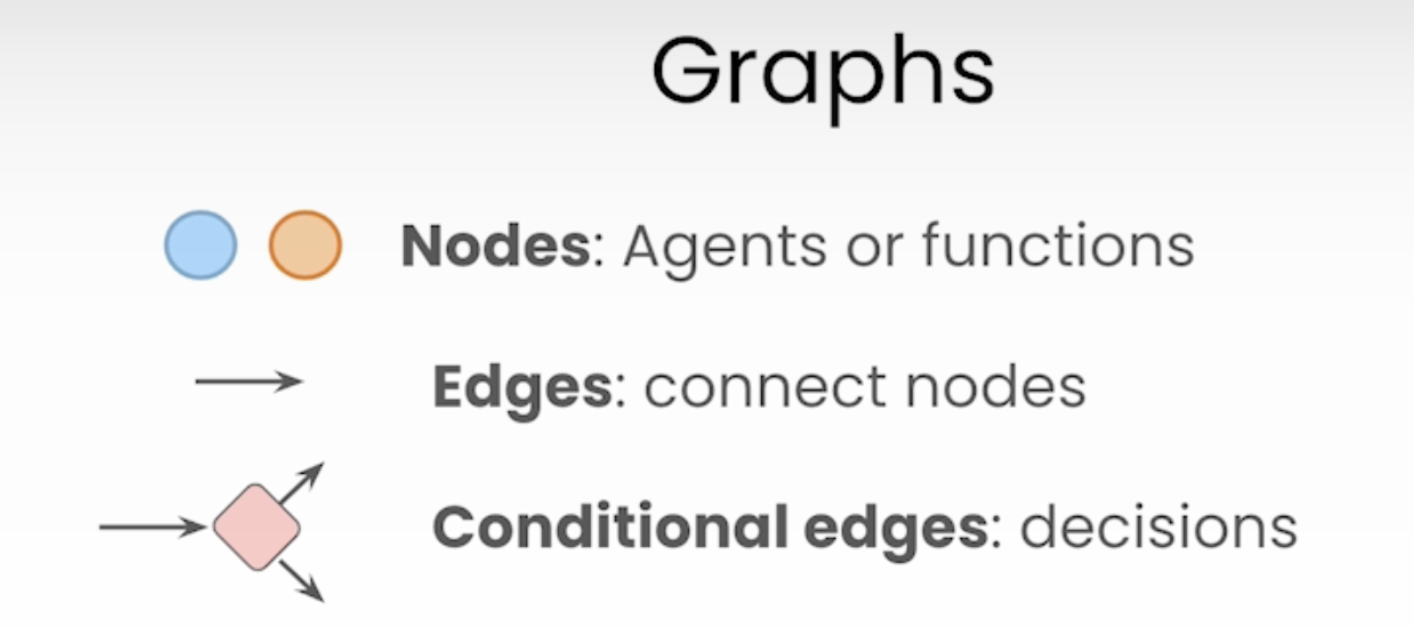

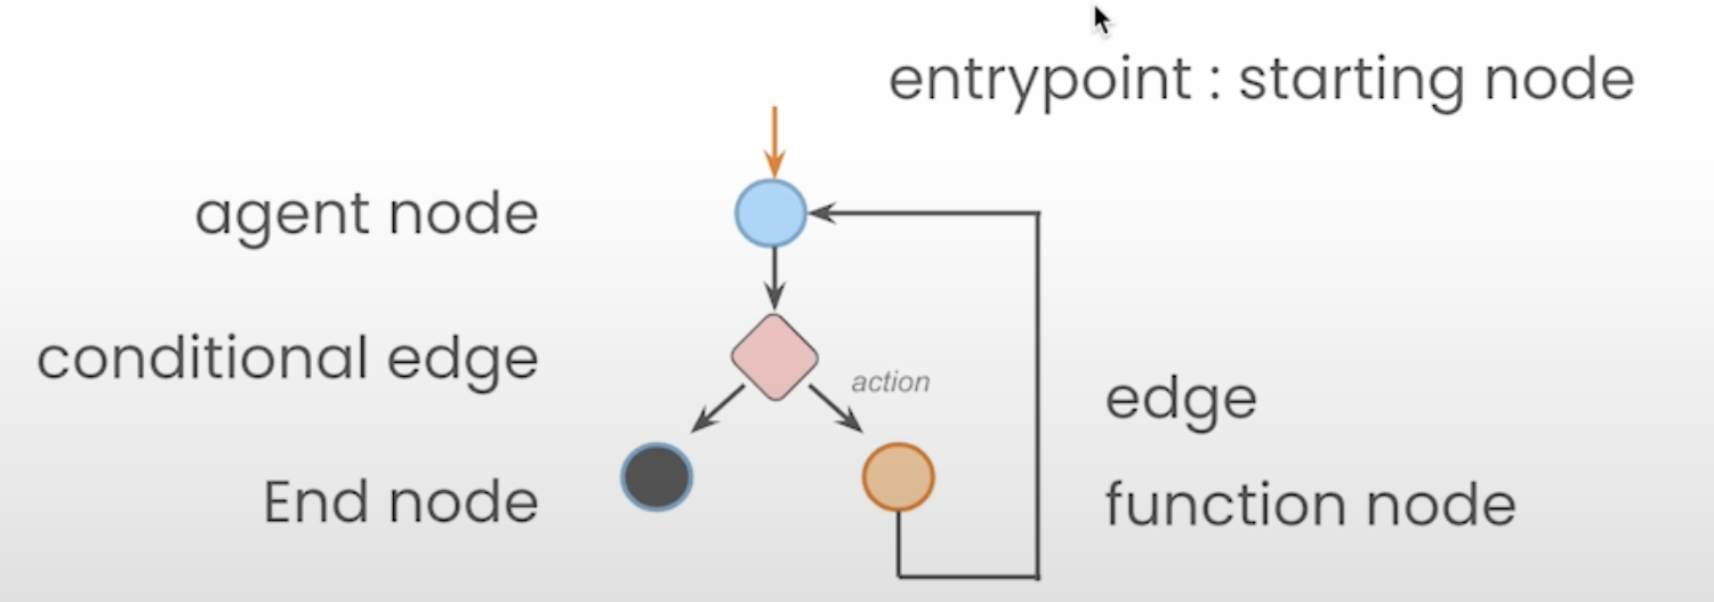

 - Dag-like graph structure
  - nodes are functions/tools or agents
  - relationships (edges) indicate flow direction
 - more execution control, better guardrails. LLM apps are more like software
 - loops (including error checking)
 - multi-agent workflows
 - complex query re-writes etc

In [7]:
import re
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}=")


_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("GOOGLE_API_KEY")

In [8]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
import os

In [9]:
# ### LLM setup
# PROJECT_ID = "seequent-labs-dev"  # @param {type:"string"}
# LOCATION = "us-west1"  # @param {type:"string"}

# import vertexai

# vertexai.init(project=PROJECT_ID, location=LOCATION)
# from langchain_google_vertexai import ChatVertexAI
# model="gemini-1.5-pro"
# llm = ChatVertexAI(model=model,temperature=0)


In [25]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0)

## Tavily Search tool
 - A popular internet search api with a good free tier

In [26]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


## Agent State
 - This is a configurable record of inputs/outputs to every graph node
 - So, if one node is a search tool, we can store the record of search queries and results in the AgentState for this node

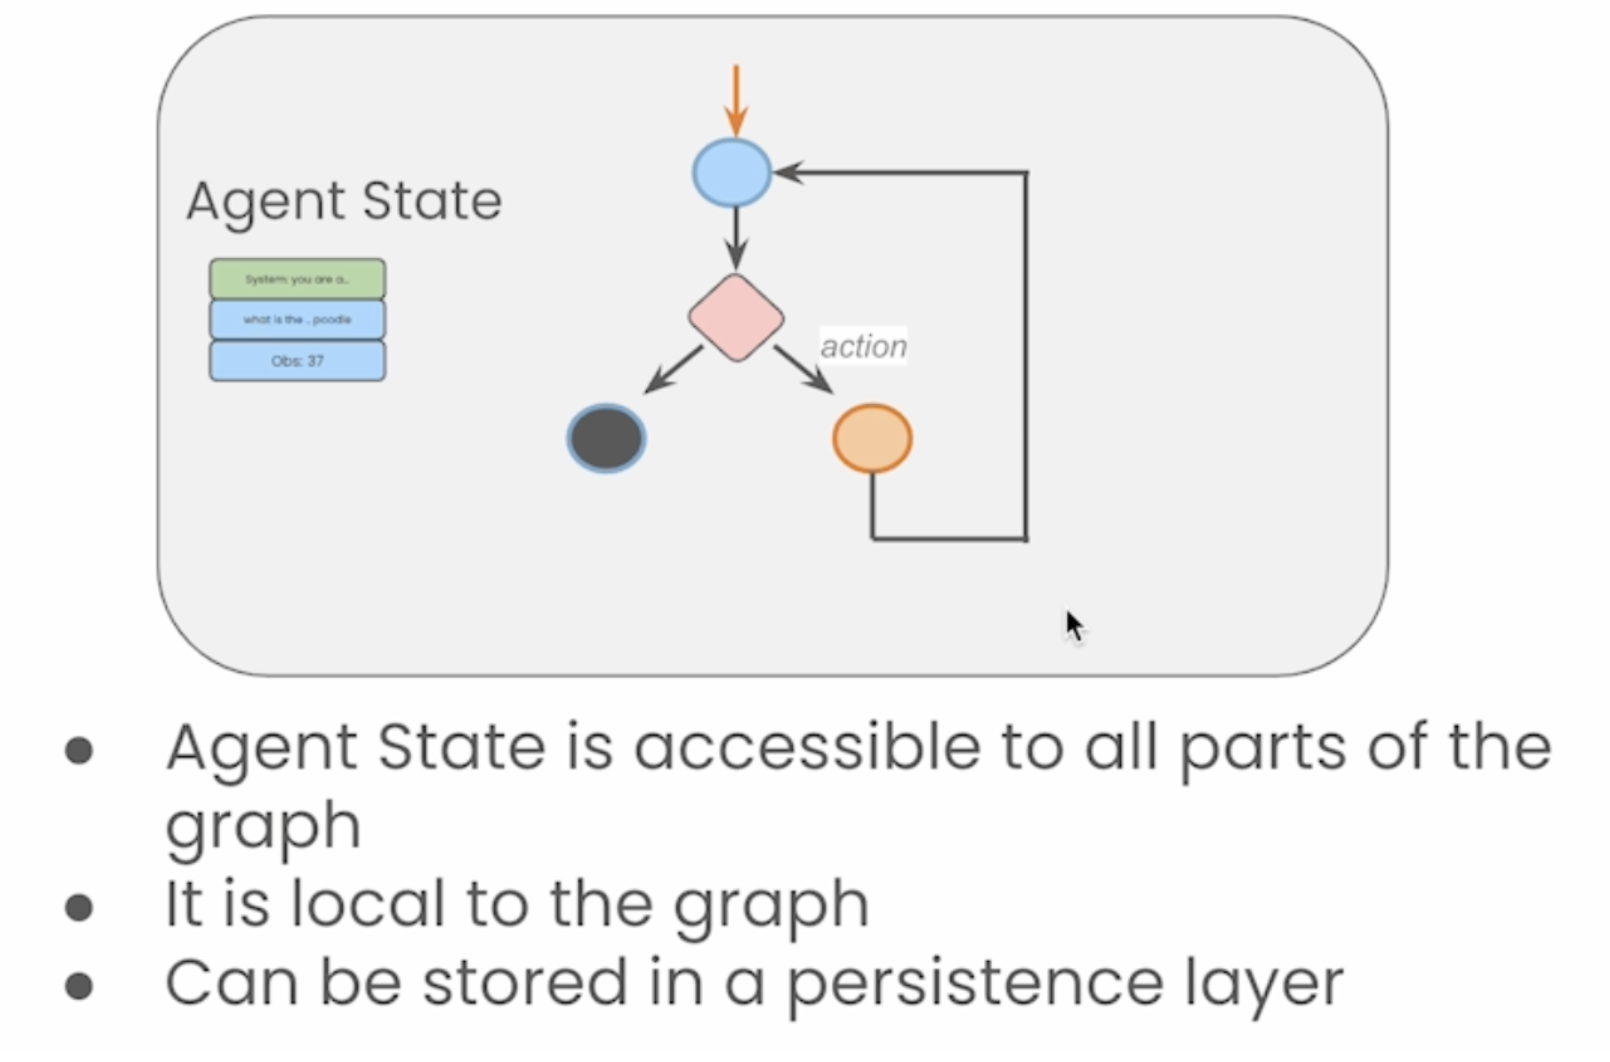

 ## AgentState and it's purpose
 - It gives the llm access to prior conversation history, so the new responces will be informed by the prior dialogue
 - Can also have more complex Agent States reducers, like Union - this one will keep just the last message
 - I'll refer to it as State or Agent State  

In [27]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]  # Annotated is a simple agent state - just add all the messages to a list


## Create an Agent with a graph inside it.
 - This graph will have just one tool - Tavily Search tool
     - In real applications, we can have more tools
     - We can also have agents as nodes in real applications (talk about that in next demo)
 - It will have a llm call node, conditional (if/else) node, END node and a search tool node
 - llm node will start the conversation and provide context for conditional node
 - Conditional node will decide between finishing the conversation and calling up the search tool
 - Search tool will look stuff up on the internet and go back to llm
    

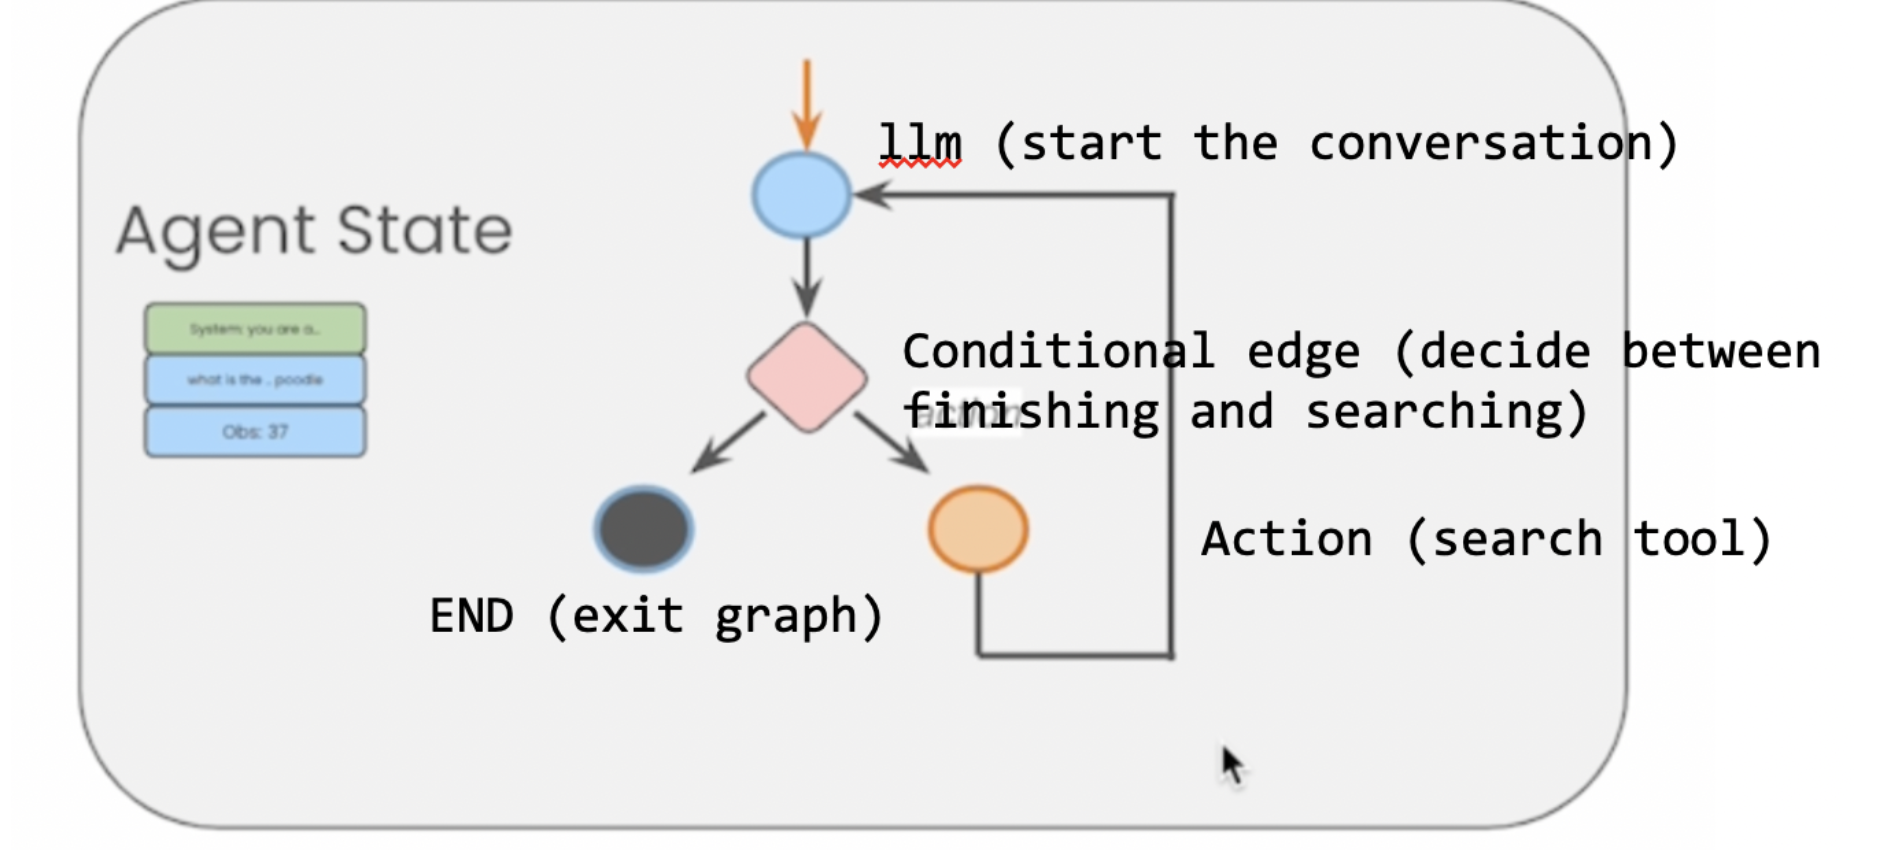

## Tool calls

This Agent is designed to interact with external tools (search engine in our case). The LLM doesn't directly execute these tools. Instead, it suggests actions to the agent by creating a tool_calls attribute on the message. Each element in this list describes a tool invocation as a tool call dict:
t = {'name':..., 'args':..., 'id':...}

t['name']: The name of the tool to be called (in our case 'tavily_search_results_json'). This string should match a key in the self.tools dictionary.

t['args']: The arguments or parameters to pass to the tool. This could be a query string for a search, a mathematical expression for a calculator, or a SQL query for a database.

t['id']: A unique identifier for this specific tool call. This is crucial for tracking results and matching them to the correct request.

### Again, the magical part:
 - langchain's tools module will extract the name of the tool and arguments we need to pass to it from the llm response and store it in a dictionary
 - We'll also add a tool_calls attribute to the tool call message that would hold this dictionary

 ```
 tool_calls = state['messages'][-1].tool_calls  # tool_calls attribute
 for t in tool_calls:
     ...
     result = self.tools[t['name']].invoke(t['args'])  # extract tool name and args from dictionary and use them
```

## Graph types: StateGraph vs MessageGraph

StateGraph:
 - Stateful applications where data (the "state") is passed between nodes. This is your go-to for most agent-based workflows and general-purpose LangChain applications.
 - Like a factory, where order of events is predefined. Build a product, then package it, then send it off
 - Most popular and convinient choice

MessageGraph:
 - Asynchronous communication between independent agents or modules. Ideal for scenarios where components need to send messages to each other without a strict, predefined execution order.
- Like email. Each node has a mailbox, and nodes can send each other emails in no particular order.

In [28]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system  # system prompt
        graph = StateGraph(AgentState)   #initiate the Langgraph
        graph.add_node("llm", self.call_llm)   # add llm and action nodes (names and associated methods)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(     # add conditional node + edges. It's an if/else node with two resultant edges
            "llm",
            self.exists_action,
            {True: "action", False: END}   # True-> maps to an action, False-> go to the END node (i.e. finish graph cycle)
        )
        graph.add_edge("action", "llm")  # add graph edges (relationships)
        graph.set_entry_point("llm")  # define which node to start the graph at
        self.graph = graph.compile()   # compile the graph. This will turn it into a langchain runnable. This allows the graph to be callable - see more here https://python.langchain.com/v0.1/docs/expression_language/interface/
        self.tools = {t.name: t for t in tools}  # add tools to a dict-like attribute for callability
        self.model = model.bind_tools(tools)  # bind tools to the model, making them calable by the llm

    def exists_action(self, state: AgentState):  # the conditional node definition
        result = state['messages'][-1]   # fetch the latest message from state
        return len(result.tool_calls) > 0  # if it's a tool call, we return True, and graph hgoes to the action node. Otherwise it goes to the END node (since no action is required)

    def call_llm(self, state: AgentState):
        messages = state['messages']  # fetch messages from State (record of all prior messages)
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages  # add the system message to the State (the initial prompt describes the Agent persona)
        message = self.model.invoke(messages) # IMPORTANT - call up the model with access to all past messages. This gives the model the context of the prior conversation
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls  # fetch the last message from State.
        # Since we're in the take_action function, the model wanted to call a tool. Hence this should be a tool_calls type message
        results = []
        for t in tool_calls:  # It can also be multiple tool calls, so we should loop through them.
            # Modern models support parallel tool calls (i.e. function calling), so we don't need to loop with those
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])  # fetch the tool via it's name from the self.tools dictionary.
                # Then pass the required args to it and invoke it.
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))  # append tool messages to results
        print("Back to the model!")
        return {'messages': results} #IMPORTANT - messages is an attribute of AgentState and our graph is an instance of it.
    # This means every time we add to messages, we'll save them to State automatically. This is one of the conviniences of langgraph

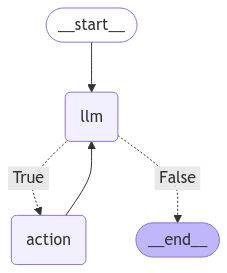

In [29]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

abot = Agent(llm, [tool], system=prompt)


from IPython.display import Image, display
display(Image(abot.graph.get_graph(xray=True).draw_mermaid_png()))

In [30]:
messages = [HumanMessage(content="What is the weather in sf?")] # have to pass the prompt in the format the class expects (list of Message-like objects)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in san francisco'}, 'id': '8fd259ed-4cee-463a-9c7d-661822665e97', 'type': 'tool_call'}
Back to the model!


In [31]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in san francisco"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a84e423d-1fc2-4be7-9d41-6f45950880b4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in san francisco'}, 'id': '8fd259ed-4cee-463a-9c7d-661822665e97', 'type': 'tool_call'}], usage_metadata={'input_tokens': 147, 'output_tokens': 13, 'total_tokens': 160, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.775, \'lon\': -122.4183, \'tz_id\': \'America/Los_Angeles\

In [32]:
result['messages'][-1].content

'The weather in San Francisco is currently partly cloudy with a temperature of 15.2°C (59.4°F). The wind is blowing from the north-northeast at 6.3 mph (10.1 kph).  The humidity is 69% and the UV index is 0.3.\n'

## Looping over tool calls
 - example below will create two tool calls and loop over them - one for SF, one for LA
 - modern models will run these in parallel instead of in a loop via function calling
 - note that sometimes it'll go back to the model, but that's not really required

In [36]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'f6060ab2-c514-4de8-87b7-8a1cddf6e46e', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': '4a629281-162f-42c6-b0a8-079c1939b9a6', 'type': 'tool_call'}
Back to the model!


In [37]:
result['messages'][-1].content

'The weather in San Francisco is partly cloudy with a temperature of 15.2°C. The wind is blowing from the NNE at 6.3 mph.\n\nThe weather in Los Angeles is sunny with a temperature of 20.6°C. The wind is blowing from the SW at 5.4 mph.\n'

## Cycling the graph
 - this example will cycle over the graph 3 times
     - first, it'll search who won the superbowl in 2024 (Kansas City Chiefs)
     - second, it'll search where Kansas City Chiefs headquarters are located (Missouri)
     - third, it'll return to the model to find the GDP of Missouri

In [38]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

abot = Agent(llm, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won super bowl 2024?'}, 'id': '35d3c0f5-b291-4aba-ad29-3ea6db7ab648', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Where are the Kansas City Chiefs headquarters located?'}, 'id': '1212280a-e727-4aaa-8976-d872a71553c9', 'type': 'tool_call'}


Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'What is the GDP of Missouri?'}, 'id': '174b5b09-dd4b-44d1-b789-de940587bb5f', 'type': 'tool_call'}


Back to the model!


In [39]:
result['messages'][-1].content

"The Kansas City Chiefs won Super Bowl LVIII in 2024.  Their headquarters are located in Kansas City, Missouri.  Missouri's real GDP in 2023 was $344.12 billion.\n"

## Magic recap
 - llm output was parsed out to a tool call

In [43]:
result['messages'][-3].content

'The Kansas City Chiefs won Super Bowl LVIII in 2024.  Their headquarters are located in Kansas City, Missouri.\n\n'

In [44]:
result['messages'][-3].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'What is the GDP of Missouri?'},
  'id': '3c86c0aa-0825-4459-98fb-3cdb7a1d70ab',
  'type': 'tool_call'}]

In [35]:
# Now try with gemini-1.5-flash. You'll see that it won't be able to use the tavily tool, as the instructions are not explicit enough